In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm

#import matplotlibmatplotlib.rcParams['axes.labelsize'] = 14
#matplotlib.rcParams['xtick.labelsize'] = 12
#matplotlib.rcParams['ytick.labelsize'] = 12
#matplotlib.rcParams['text.color'] = 'k'

Time series forecasting is the use of a model to predict future values based on previously observed values.  
Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post

In [3]:
df = pd.read_excel("/home/johan/repos/GitHub/Time-SeriesForecasting/Data/Sample - Superstore.xls")
#print(df[0:2])
furniture = df.loc[df['Category'] == 'Furniture']

In [4]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [5]:
furniture[0:2]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [6]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)

In [7]:
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [8]:
#furniture = furniture.groupby('Order Date')
#furniture['Sales'].sum().reset_index()
#print(furniture[0:4])

In [9]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-13', '2014-01-14', '2014-01-16',
               '2014-01-19', '2014-01-20',
               ...
               '2017-12-28', '2017-12-28', '2017-12-28', '2017-12-29',
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=2121, freq=None)

In [19]:
print('furniture[Sales].shape:',furniture['Sales'].shape)
y = furniture['Sales'].resample('MS').mean()
print('y:',y[1],'shape:', y.shape)

furniture[Sales].shape: (2121,)
y: 262.8082857142857 shape: (48,)


In [20]:
y['2017':]

Order Date
2017-01-01    248.501333
2017-02-01    264.089900
2017-03-01    286.669600
2017-04-01    206.044502
2017-05-01    319.953928
2017-06-01    372.717386
2017-07-01    227.173500
2017-08-01    395.945487
2017-09-01    349.737422
2017-10-01    308.226313
2017-11-01    374.310253
2017-12-01    296.296857
Freq: MS, Name: Sales, dtype: float64

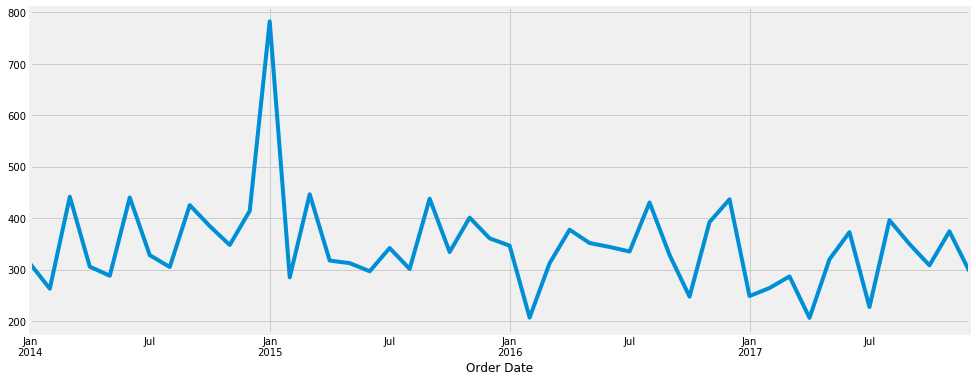

In [21]:
y.plot(figsize=(15, 6))
plt.show()

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

**Systematic:** Components of the time series that have consistency or recurrence and can be described and modeled.   
**Non-Systematic:**Components of the time series that cannot be directly modeled.

A given time series is thought to consist of **three systematic components including level, trend, seasonality, and one non-systematic component called noise.**

These components are defined as follows:

**Level:** The average value in the series.   
**Trend:** The increasing or decreasing value in the series.   
**Seasonality:** The repeating short-term cycle in the series.  
**Noise:** The random variation in the series.  


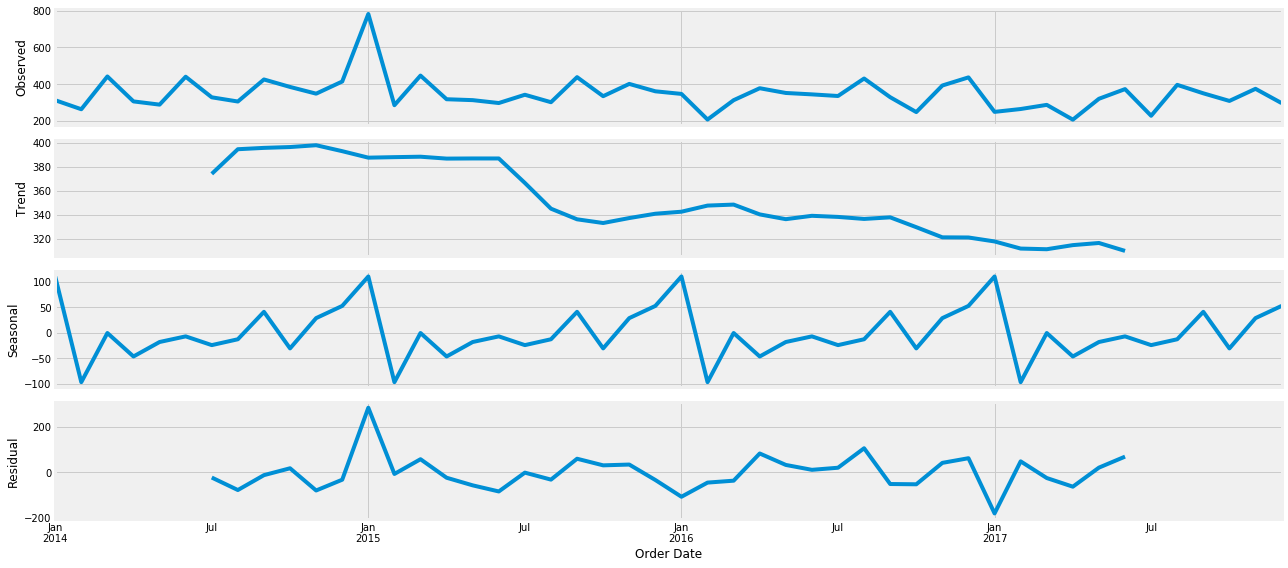

In [23]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

# Time series forecasting with ARIMA
 Autoregressive Integrated Moving Average.

In [27]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [30]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:688.3112416991725


/home/johan/anaconda2/envs/tensorflow_py3/lib/python3.5/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1463.47997004893
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:426.20464898591723
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:452.8238602501692
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:421.17561100533345
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:295.446456472235
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:641.1240680666
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2957.532452123898
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:416.5496453364607


/home/johan/anaconda2/envs/tensorflow_py3/lib/python3.5/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:455.1443143116624


/home/johan/anaconda2/envs/tensorflow_py3/lib/python3.5/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:411.5792967220806
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:297.4464066250234
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:580.6389269668506
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1267.511368354938
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:433.35521367347195
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:437.46040107889746


/home/johan/anaconda2/envs/tensorflow_py3/lib/python3.5/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1340.6635138917418
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:294.1158452476944
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:538.8964721447164
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2349.2478072353424
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:412.87269899050756
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:419.1839792724938
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:3161.488085330586
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:273.40324546363263
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:592.7661498749849


/home/johan/anaconda2/envs/tensorflow_py3/lib/python3.5/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1203.7698381874575
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:427.72411597383274
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:420.41145389920376
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:422.29220651940904
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:273.5840395565934
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:553.2719417804199
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2677.8740379108594
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:418.52617830891063
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:422.40035833228546
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:388.5413708532963
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:275.47757405307635
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:566.5211872508684


/home/johan/anaconda2/envs/tensorflow_py3/lib/python3.5/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1114.985855476997
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:430.3305770817938
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:397.36689816515747


/home/johan/anaconda2/envs/tensorflow_py3/lib/python3.5/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1415.9280110512773
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:273.4415398792929
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:540.6257368397359
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2382.2792279707587
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:414.77261730418525
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:391.83032557049955
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:3048.7621645036693
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:263.9371084381262


The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 297.78. Therefore we should consider this to be optimal option.

In [32]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0771      0.259     -0.298      0.766      -0.584       0.430
ma.L1         -1.0000      0.434     -2.305      0.021      -1.850      -0.150
ar.S.L12      -0.0007      0.029     -0.025      0.980      -0.057       0.056
sigma2      6323.9742   6.86e-05   9.22e+07      0.000    6323.974    6323.974


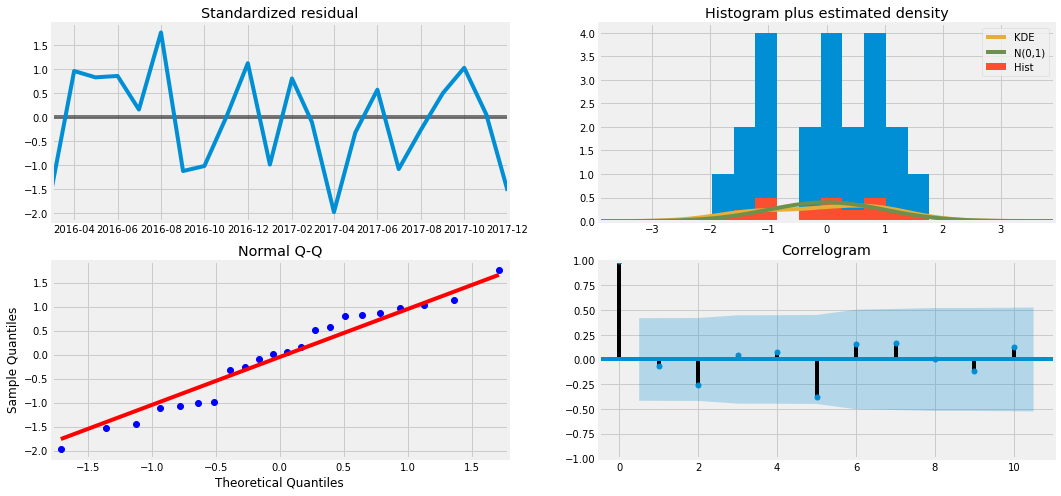

In [33]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

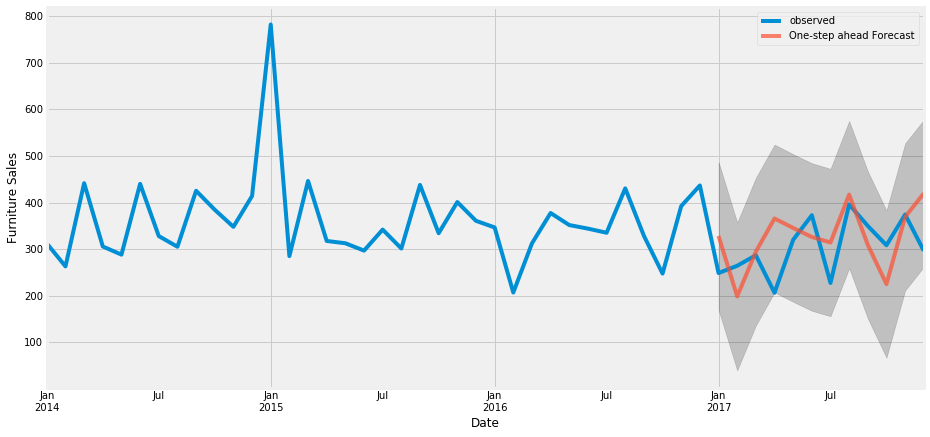

In [39]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [40]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 5911.26


In [41]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 76.88


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.